# Baselines and Formulation


## Data Preparation

In [ ]:
# Install and start postgresql-11 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-11 postgresql-client-11
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=postgres
%env DEMO_DATABASE_PASS=postgres

In [ ]:
# Download sampled DonorsChoose data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/donors_sampled_20210920_v3.dmp
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 donors_sampled_20210920_v3.dmp
!pip install SQLAlchemy==1.3.18 PyYAML==6.0 psycopg2-binary==2.9.3
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

db_url = URL(
            'postgres',
            host='localhost',
            username='postgres',
            database='donors_choose',
            password='postgres',
            port=5432,
        )

db_engine = create_engine(db_url)
full_projects = pd.read_sql("SELECT * FROM data.projects", db_engine)
full_resources = pd.read_sql("SELECT * FROM data.resources", db_engine)
full_donations = pd.read_sql("SELECT * FROM data.donations", db_engine)


full_projects=full_projects.rename(columns = {'projectid_str':'projectid', "total_asking_price":"total_price_excluding_optional_support"})
full_donations = full_donations.rename(columns = {'projectid_str':'projectid'})

In [ ]:
!pip install kaggle

!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
api_token = {"username":"ploped123","key":"eeeeba8fc52706723e4c1bcf41ae6fd3"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c kdd-cup-2014-predicting-excitement-at-donors-choose

In [ ]:
!ls /content

In [ ]:
!unzip /content/kdd-cup-2014-predicting-excitement-at-donors-choose.zip

In [ ]:
!unzip /content/resources.csv.zip
!unzip /content/donations.csv.zip

In [ ]:
!unzip /content/projects.csv.zip

## Obtain df

In [3]:
import json
import zipfile
import os
import pandas as pd
import numpy as np

In [4]:
full_donations = pd.read_csv("/content/donations.csv")
full_projects = pd.read_csv("/content/projects.csv")
# full_essays = pd.read_csv("essays.csv")
full_resources = pd.read_csv("/content/resources.csv")

In [5]:
from datetime import timedelta
!pip install textstat
!pip install flair

import textstat

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

import flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Feature Engineering

In [6]:
a = pd.merge(full_projects, full_donations, on=['projectid'], how='left')
a['in_4_months'] = (pd.to_datetime(a['donation_timestamp']) - pd.to_datetime(a['date_posted'])) < timedelta(days=120)
a['in_1_months'] = (pd.to_datetime(a['donation_timestamp']) - pd.to_datetime(a['date_posted'])) < timedelta(days=30)
a['donation_1mo'] = a['donation_to_project'].values
values = {'donation_to_project': 0.0}
a = a.fillna(value=values)
a.loc[a['in_4_months'] == False, 'donation_to_project'] = 0.0
a.loc[a['in_1_months'] == False, 'donation_1mo'] = 0.0

donation_in_4_months = a.groupby(['projectid'])['donation_to_project'].sum().reset_index(name='donation_in_4_months')
donation_in_1_months = a.groupby(['projectid'])['donation_1mo'].sum().reset_index(name='donation_in_1_months')
df = pd.merge(full_projects, donation_in_4_months, on=['projectid'], how='left')
df = pd.merge(df, donation_in_1_months, on=['projectid'], how='left')

del a

In [7]:
df['is_fully_funded_after_4_months'] = df['total_price_excluding_optional_support'] <= df['donation_in_4_months']
df['fund percentage'] = df['donation_in_4_months'] / df['total_price_excluding_optional_support']

# df['is_fully_funded_after_4_months'] = df['total_asking_price'] <= df['donation_in_4_months']
df['is_fully_funded_after_4_months'].value_counts()
print("Baserate % projects fully funded:", df['is_fully_funded_after_4_months'].mean())

df['pct_funded_1mo'] = df['donation_in_1_months'] / df['total_price_excluding_optional_support']
df['is_fully_funded_after_1_months'] = df['total_price_excluding_optional_support'] <= df['donation_in_1_months']
#df['is_fully_funded_after_1_months'] = df['total_asking_price'] <= df['donation_in_1_months']
df['is_fully_funded_after_1_months'].value_counts()
print("Baserate % projects fully funded 1mo:", df['is_fully_funded_after_1_months'].mean())
df['fund percentage']

Baserate % projects fully funded: 0.5480215269433126
Baserate % projects fully funded 1mo: 0.30470804007842217


0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
664093    1.099567
664094    1.099203
664095    1.000000
664096    1.000000
664097    1.000000
Name: fund percentage, Length: 664098, dtype: float64

In [8]:
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['children_helped_per_dollar'] = df['students_reached']/df['total_price_excluding_optional_support']

In [9]:
from sklearn.preprocessing import OneHotEncoder
one_hot_feature_cols = ['grade_level', 'teacher_prefix', 'school_state']
df = df.replace({'school_charter': {'t': 1, 'f': 0},
                 'school_kipp': {'t': 1, 'f': 0}})

encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding
encoder_df = pd.DataFrame(encoder.fit_transform(df[one_hot_feature_cols]).toarray())
encoder_df.columns = encoder.get_feature_names_out()
#merge one-hot encoded columns back with original DataFrame
final_X = df.join(encoder_df)
#drop the original columns
final_X = final_X.drop(one_hot_feature_cols, axis=1)

df = final_X

# # row 28-36
feature_cols_projects = ['school_charter', 'school_kipp', 'total_price_excluding_optional_support', 'students_reached', 'teacher_acctid', 'school_city', 'date_posted'] + list(final_X.columns[-50:])

In [10]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_zip',
       'school_metro', 'school_district',
       ...
       'school_state_SD', 'school_state_TN', 'school_state_TX',
       'school_state_UT', 'school_state_VA', 'school_state_VT',
       'school_state_WA', 'school_state_WI', 'school_state_WV',
       'school_state_WY'],
      dtype='object', length=102)

In [11]:
import numpy as np

In [12]:
resource_df = full_resources[['resourceid', 'projectid', 'project_resource_type', 'item_unit_price', 'item_quantity']]
resource_df['project_resource_type'] = resource_df['project_resource_type'].astype('str')

# Fill in missing values of item_unit_price & item_quantity
resource_types = np.unique(resource_df['project_resource_type'].tolist())
avg_unit_price = {}
avg_quantity = {}
for rtype in resource_types:
  avg = resource_df.loc[resource_df['project_resource_type'] == rtype]['item_unit_price'].mean()
  avg_unit_price[rtype] = avg
  avg_num = np.floor(resource_df.loc[resource_df['project_resource_type'] == rtype]['item_quantity'].mean())
  avg_quantity[rtype] = avg_num

resource_df['avg_unit_price'] = resource_df.apply(lambda row: avg_unit_price[row['project_resource_type']], axis=1) # This could take a minute to run
resource_df['avg_quantity'] = resource_df.apply(lambda row: avg_quantity[row['project_resource_type']], axis=1)

resource_df['item_unit_price'] = resource_df['item_unit_price'].fillna(resource_df['avg_unit_price'])
resource_df['item_quantity'] = resource_df['item_quantity'].fillna(resource_df['avg_quantity'])

resource_df = resource_df.groupby('projectid').agg({'item_unit_price':'mean', 'item_quantity':'sum'}).reset_index().rename(columns={'item_unit_price':'avg_unit_price', 'item_quantity':'total_item_quantity'})
df = df.merge(resource_df, how='left', on='projectid')

<ipython-input-12-4fa936b62856>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resource_df['project_resource_type'] = resource_df['project_resource_type'].astype('str')
<ipython-input-12-4fa936b62856>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resource_df['avg_unit_price'] = resource_df.apply(lambda row: avg_unit_price[row['project_resource_type']], axis=1) # This could take a minute to run
<ipython-input-12-4fa936b62856>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [13]:
resstat_cols = ['students_reached', 'children_helped_per_dollar', 'primary_focus_area', 'resource_type', 'poverty_level']

#text_cols = ['title_len', 'title_sentnet', 'title_sentpol', 'short_description_len', 'short_description_sentnet', 'short_description_sentpol','essay_len', 'need_statement_len']
res_cols = ['avg_unit_price', 'total_item_quantity']
don_cols = ['pct_funded_1mo']
features = resstat_cols + res_cols + don_cols + feature_cols_projects + ['projectid'] + ['fund percentage']
Y = ['is_fully_funded_after_4_months']
print()
df_final = df[features + Y]

# Silences a warning that doesn't affect anything
pd.options.mode.chained_assignment = None

for i in ['primary_focus_area', 'resource_type', 'poverty_level']:
  new_addition = pd.get_dummies(df_final[i])
  new_addition.columns = [i + ":" + x.replace(" ","_") for x in new_addition.columns]
  for col_name in new_addition.columns:
    df_final[col_name] = new_addition[col_name].copy(deep=True)
df_final.drop(columns = ['primary_focus_area', 'resource_type', 'poverty_level'], inplace=True)
print(df_final.columns)


Index(['students_reached', 'children_helped_per_dollar', 'avg_unit_price',
       'total_item_quantity', 'pct_funded_1mo', 'school_charter',
       'school_kipp', 'total_price_excluding_optional_support',
       'students_reached', 'teacher_acctid', 'school_city', 'date_posted',
       'school_state_AR', 'school_state_AZ', 'school_state_CA',
       'school_state_CO', 'school_state_CT', 'school_state_DC',
       'school_state_DE', 'school_state_FL', 'school_state_GA',
       'school_state_HI', 'school_state_IA', 'school_state_ID',
       'school_state_IL', 'school_state_IN', 'school_state_KS',
       'school_state_KY', 'school_state_LA', 'school_state_La',
       'school_state_MA', 'school_state_MD', 'school_state_ME',
       'school_state_MI', 'school_state_MN', 'school_state_MO',
       'school_state_MS', 'school_state_MT', 'school_state_NC',
       'school_state_ND', 'school_state_NE', 'school_state_NH',
       'school_state_NJ', 'school_state_NM', 'school_state_NV',
       'school_

In [14]:
from datetime import datetime

In [15]:
from dateutil.relativedelta import relativedelta

In [16]:
def chron_split_date_ranges(dates, train_length = relativedelta(weeks=3), val_length = relativedelta(weeks=1), retrain_length = relativedelta(weeks=2), min_f_col = relativedelta(months=1), min_l_col = relativedelta(months=4)):
  sorted = dates.sort_values()
  first_date = sorted.iloc[0]
  last_date = sorted.iloc[-1]

  split_dates = []

  curr = first_date

  while curr + val_length + train_length + 2 * min_l_col + 2 * min_f_col < last_date:
    train_start = curr + min_f_col
    val_start = train_start + train_length + min_l_col + min_f_col
    
    split_dates.append({
        "train_feature_collection": (curr, train_start),
        "train": (train_start, train_start + train_length),
        "train_label_buffer": (train_start + train_length, train_start + train_length + min_l_col),
        "val_feature_collection": (train_start + train_length + min_l_col, val_start),
        "val": (val_start , val_start + val_length),
        "val_label_buffer": (val_start + val_length, val_start + val_length + min_l_col),
        "train_label": (train_start + min_l_col, train_start + train_length + min_l_col),
        "val_label": (val_start + min_l_col, val_start + val_length + min_l_col)
    })

    curr += retrain_length
  return split_dates

In [17]:
split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))[-1]  
#split1 = chron_split_date_ranges(pd.to_datetime(df['date_posted']))[-2]  
#split2 = chron_split_date_ranges(pd.to_datetime(df['date_posted']))[-3]  
#split3 = chron_split_date_ranges(pd.to_datetime(df['date_posted']))[-4]  

In [18]:
# compute success rate grouped by 'feature', only use historical data
def compute_success_rate_by_feature(data, date, feature_names):
  data_before_date = df_final[df_final['date_posted'] < (date - timedelta(days=120))]
  for feature_name in feature_names:
    num_of_success = dict(data_before_date.groupby([feature_name])['is_fully_funded_after_4_months'].sum())
    num_of_projects = dict(data_before_date.groupby([feature_name]).size())
    data['num_of_success_projects_' + feature_name]= data[feature_name].map(num_of_success)
    data['num_of_projects_' + feature_name]= data[feature_name].map(num_of_projects)
    data['success_rate_' + feature_name]= data['num_of_success_projects_' + feature_name] / data['num_of_projects_' + feature_name]
    #drop 'school city'
  data = data.drop(feature_names + ['projectid', 'date_posted'], axis=1)
  data = data.fillna(0)

  return data

def generate_train_val(df, split):
  train = df.loc[(split["train"][0] <= df['date_posted']) & (df['date_posted'] < split["train"][1])].fillna(0)
  train = compute_success_rate_by_feature(train, split["train"][0], ['school_city', 'teacher_acctid'])

  val = df.loc[(split["val"][0] <= df['date_posted']) & (df['date_posted'] < split["val"][1])].fillna(0)
  val = compute_success_rate_by_feature(val, split["train"][0], ['school_city', 'teacher_acctid'])
  return pd.DataFrame(train), pd.DataFrame(val)


In [19]:
train, val = generate_train_val(df_final, split)
#train1, val1 = generate_train_val(df_final, split1)
#train2, val2 = generate_train_val(df_final, split2)
#train3, val3 = generate_train_val(df_final, split3)

In [20]:
train_X = train.drop(columns=['is_fully_funded_after_4_months', 'fund percentage']).reset_index()
train_Y = train['fund percentage'] #train['is_fully_funded_after_4_months'].values
val_X = val.drop(columns=['is_fully_funded_after_4_months', 'fund percentage']).reset_index()
val_Y = val['fund percentage'].values

def drop_columns(train, val):
  train_X = train.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  train_Y = train['is_fully_funded_after_4_months'].values
  val_X = val.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  val_Y = val['is_fully_funded_after_4_months'].values
  return train_X, train_Y, val_X, val_Y

In [21]:
del df

# Gaussian Process Regression

In [ ]:
selected = ['pct_funded_1mo', 'children_helped_per_dollar', 'poverty_level:moderate_poverty']
xx = train_X[selected]
vx = val_X[selected]
xx.shape

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
import time
start = time.time()
kernel = DotProduct() + WhiteKernel()
regressor = GaussianProcessRegressor(kernel=kernel, copy_X_train=False)
regressor.fit(xx, train_Y)
predictions = regressor.predict(vx)
end = time.time()
print(end - start)
acc = 0
for i in range(len(predictions)):
  if predictions[i] >= 1 and val_Y[i] >= 1:
    acc += 1
  elif predictions[i] < 1 and val_Y[i] < 1:
    acc += 1
print(acc / len(predictions))
print(regressor.score(xx, train_Y))

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
kernel = RBF(length_scale=10, length_scale_bounds=(1e-200, 1e20)) # 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)) 
regressor = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, copy_X_train=False)
regressor.fit(xx, train_Y)
predictions = regressor.predict(vx)
print(predictions)
acc = 0
for i in range(len(predictions)):
  if predictions[i] >= 1 and val_Y[i] >= 1:
    acc += 1
  elif predictions[i] < 1 and val_Y[i] < 1:
    acc += 1
print(acc / len(predictions))
print(regressor.score(xx, train_Y))

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
kernel = WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e+1))
regressor = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, copy_X_train=False)
regressor.fit(xx, train_Y)
predictions = regressor.predict(vx)
print(predictions)
acc = 0
for i in range(len(predictions)):
  if predictions[i] >= 1 and val_Y[i] >= 1:
    acc += 1
  elif predictions[i] < 1 and val_Y[i] < 1:
    acc += 1
print(acc / len(predictions))
print(regressor.score(xx, train_Y))

In [ ]:
from sklearn.neural_network import MLPRegressor
max_res = 0
feature_selected = None
selected = ["pct_funded_1mo", "children_helped_per_dollar"]

def grid_search(train_X, train_Y):
  maxres = 0
  for num in range(5, 300, 5):
    start = time.time()
    model = MLPRegressor(hidden_layer_sizes=(num, num, num), activation='relu', random_state=1, max_iter=5000)
    model.fit(train_X[selected], train_Y)
    train_pred = model.predict(train_X[selected])
    val_pred = model.predict(val_X[selected]) 
    acc = 0
    end = time.time()
    print(end - start)
    for i in range(len(val_pred)):
      if val_pred[i] >= 1 and val_Y[i] >= 1:
        acc += 1
      elif val_pred[i] < 1 and val_Y[i] < 1:
        acc += 1
    curacc = acc / len(val_pred)
    if curacc > maxres:
      maxres = curacc
  print(maxres)
grid_search(train_X, train_Y)

# ML Baselines

## NN

grid search -- parameters over last 2nd, 3rd, and 4th splits

In [ ]:
from sklearn.neural_network import MLPRegressor
max_res = 0
feature_selected = None
selected = ["pct_funded_1mo", "children_helped_per_dollar"]
maxres = 0
maxnum = 0
def grid_search(train_X, train_Y):
  for num in range(5, 300, 5):
    model = MLPRegressor(hidden_layer_sizes=(num, num, num), activation='relu', random_state=1, max_iter=5000)
    model.fit(train_X[selected], train_Y)
    train_pred = model.predict(train_X[selected])
    val_pred = model.predict(val_X[selected]) 
    train_rank = np.argsort(train_pred)
    val_rank = np.argsort(val_pred)
    results = []
    for threshold in np.linspace(0.01, 1, 100):
      precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
      precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
      recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
      recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
      results.append([precision_train, recall_train, precision_val, recall_val])
    results = np.array(results)
    print(results[9, 2]) 
    if maxres < results[9, 2]:
      maxres = results[9, 2]
      maxnum = num
  print("optimal: ", maxres, maxnum)

grid search -- features  over last 2nd, 3rd, and 4th splits

In [ ]:
from sklearn.neural_network import MLPRegressor
max_res = 0
feature_selected = None
def feature_search(train_X, train_Y):
  for i in train_X.columns[1:]:
    selected = ['pct_funded_1mo', 'children_helped_per_dollar', 'students_reached'] #["pct_funded_1mo", "children_helped_per_dollar"]
    selected.append(i)
    #print(selected) 
    #print(train_X[selected])
    # creating a MLP model
    model = MLPRegressor(hidden_layer_sizes=(10,10), activation='tanh', random_state=1, max_iter=500)
    model.fit(train_X[selected], train_Y)
    train_pred = model.predict(train_X[selected])
    val_pred = model.predict(val_X[selected]) 
    #print(val_pred)
    train_rank = np.argsort(train_pred)
    val_rank = np.argsort(val_pred)
    results = []
    for threshold in np.linspace(0.01, 1, 100):
        precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
        precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
        recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
        recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
        results.append([precision_train, recall_train, precision_val, recall_val])
    results = np.array(results)
    print(results[9, 2]) 
    if max_res < results[9, 2]:
      max_res = results[9, 2]
      feature_selected = selected
  print(max_res, feature_selected)

results over time

In [ ]:
whole_split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))
selected = ['pct_funded_1mo', 'children_helped_per_dollar', 'students_reached', 'num_of_success_projects_teacher_acctid']
lr_res = []
for s in whole_split:
  #print(s)
  curtrain, curval = generate_train_val(df_final, s)
  curtrain_X = curtrain.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curtrain_Y = curtrain['is_fully_funded_after_4_months'].values
  curval_X = curval.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curval_Y = curval['is_fully_funded_after_4_months'].values
  curtrain_X[np.isinf(curtrain_X)==True] = 0
  curval_X[np.isinf(curval_X)==True] = 0
  logmodel = MLPRegressor(hidden_layer_sizes=(10,10), activation='tanh', random_state=1, max_iter=500)
  logmodel.fit(curtrain_X[selected], curtrain_Y)
  train_pred = logmodel.predict(curtrain_X[selected])
  val_pred = logmodel.predict(curval_X[selected]) # f(x)
  res = logmodel.predict(curval_X[selected]) # f(x)>0.5
  train_rank = np.argsort(train_pred)
  val_rank = np.argsort(val_pred)
  results = []
  threshold = 0.1
  precision_val = 1 - np.mean(curval_Y[val_rank][:int(threshold * len(curval_X))])
  print(precision_val)  
  lr_res.append(precision_val)

In [ ]:
(lr_res[-2]+lr_res[-4]+lr_res[-3])/3

0.8574956540974523

In [ ]:
file1 = open('nn.txt', 'w')
file1.writelines(str(lr_res))
file1.close()

most recent PR-K graphs

In [ ]:
selected = ['pct_funded_1mo', 'children_helped_per_dollar', 'students_reached'] #["pct_funded_1mo", "children_helped_per_dollar"]
model = MLPRegressor(hidden_layer_sizes=(10,10), activation='tanh', random_state=1, max_iter=500)
model.fit(train_X[selected], train_Y)
train_pred = model.predict(train_X[selected])
val_pred = model.predict(val_X[selected]) 
train_rank = np.argsort(train_pred)
val_rank = np.argsort(val_pred)
results = []
for threshold in np.linspace(0.01, 1, 100):
    precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
    precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
    recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
    recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
    results.append([precision_train, recall_train, precision_val, recall_val])
results = np.array(results)
print(results[9, 2])  # 0.683 for l2

0.9323144104803494


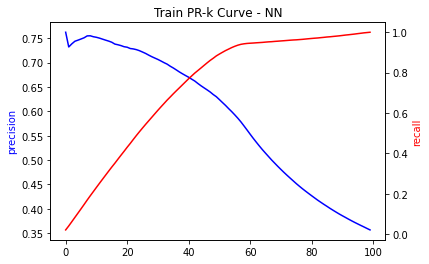

In [ ]:
import matplotlib.pyplot as plt

ax1 = plt.subplot()
plt.plot(range(100), results[:,0], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,1], 'r')
plt.ylabel('recall', color='r')
plt.title("Train PR-k Curve - NN")
plt.xlabel("Percentage of population selected")
plt.show()

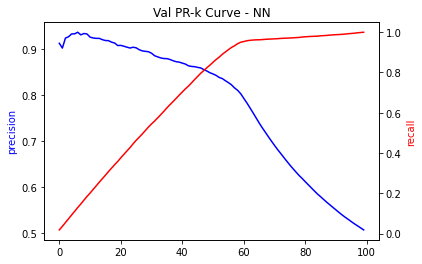

In [ ]:
ax1 = plt.subplot()
plt.plot(range(100), results[:,2], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,3], 'r')
plt.ylabel('recall', color='r')
plt.title("Val PR-k Curve - NN")
plt.show()

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
import time

grid search feature selection

In [53]:
max_res = 0
feature_selected = None
for i in train_X.columns[1:]:
  selected = ["pct_funded_1mo", "children_helped_per_dollar"]
  selected.append(i)
  #print(selected) 
  #print(train_X[selected])
  start = time.time()
  logmodel = LogisticRegression(penalty='none', max_iter=100000000)
  logmodel.fit(train_X[selected], train_Y)
  train_pred = logmodel.predict_proba(train_X[selected])
  val_pred = logmodel.predict_proba(val_X[selected]) # f(x)
  res = logmodel.predict(val_X[selected]) # f(x)>0.5
  train_rank = np.argsort(train_pred[:,1])
  val_rank = np.argsort(val_pred[:,1])
  results = []
  for threshold in np.linspace(0.01, 1, 100):
      precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
      precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
      recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
      recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
      results.append([precision_train, recall_train, precision_val, recall_val])
  results = np.array(results)
  #print(results[9, 2]) 
  if max_res < results[9, 2]:
    max_res = results[9, 2]
    feature_selected = selected
print(max_res, feature_selected)

NameError: ignored

most recent PR-K graphs

In [ ]:
selected = feature_selected
start = time.time()
logmodel = LogisticRegression(penalty='none', max_iter=100000000)
logmodel.fit(train_X[selected], train_Y)
runtime = time.time() - start
print(runtime)

In [ ]:
#print(val_X)

In [ ]:
train_pred = logmodel.predict_proba(train_X[selected])
val_pred = logmodel.predict_proba(val_X[selected]) # f(x)
res = logmodel.predict(val_X[selected]) # f(x)>0.5

In [ ]:
print(val_pred[:,1])

In [ ]:
print(res)

In [ ]:
train_rank = np.argsort(train_pred[:,1])
val_rank = np.argsort(val_pred[:,1])

In [ ]:
results = []
for threshold in np.linspace(0.01, 1, 100):
    precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
    precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
    recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
    recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
    results.append([precision_train, recall_train, precision_val, recall_val])
results = np.array(results)
print(results[9, 2])  # 0.683 for l2

In [ ]:
import matplotlib.pyplot as plt

ax1 = plt.subplot()
plt.plot(range(100), results[:,0], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,1], 'r')
plt.ylabel('recall', color='r')
plt.title("Train PR-k Curve - Logistic Regression")
plt.xlabel("Percentage of population selected")
plt.show()

In [ ]:
ax1 = plt.subplot()
plt.plot(range(100), results[:,2], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,3], 'r')
plt.ylabel('recall', color='r')
plt.title("Val PR-k Curve - Logistic Regression")
plt.show()

In [ ]:
# train_X.columns[np.argsort(logmodel.feature_importances_)[::-1]]

whole dataset evaluation (precision, recall, tfp)

In [ ]:
whole_split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))

In [ ]:
lr_res = []
for s in whole_split:
  #print(s)
  curtrain, curval = generate_train_val(df_final, s)
  curtrain_X = curtrain.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curtrain_Y = curtrain['is_fully_funded_after_4_months'].values
  curval_X = curval.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curval_Y = curval['is_fully_funded_after_4_months'].values
  #curtrain_X.dropna(inplace=True)
  #indices_to_keep = ~curtrain_X.isin([np.nan, np.inf, -np.inf]).any(axis=1)
  #curtrain_X[indices_to_keep].astype(np.float64)
  #curtrain_X.dropna(inplace=True)
  curtrain_X[np.isinf(curtrain_X)==True] = 0
  curval_X[np.isinf(curval_X)==True] = 0
  logmodel = LogisticRegression(penalty='none', max_iter=100000000)
  logmodel.fit(curtrain_X[selected], curtrain_Y)
  train_pred = logmodel.predict_proba(curtrain_X[selected])
  val_pred = logmodel.predict_proba(curval_X[selected]) # f(x)
  res = logmodel.predict(curval_X[selected]) # f(x)>0.5
  train_rank = np.argsort(train_pred[:,1])
  val_rank = np.argsort(val_pred[:,1])
  results = []
  threshold = 0.1
  #precision_train = 1 - np.mean(curtrain_Y[train_rank][:int(threshold * len(curtrain_X))])
  precision_val = 1 - np.mean(curval_Y[val_rank][:int(threshold * len(curval_X))])
  #recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
  #recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
  # results.append([precision_train, recall_train, precision_val, recall_val])
  # results = np.array(results)
  print(precision_val)  # 0.683 for l2
  lr_res.append(precision_val)

In [ ]:
file1 = open('lr.txt', 'w')
file1.writelines(str(y_value))
file1.close()

most recent graph

In [ ]:
selected = feature_selected
start = time.time()
logmodel = LogisticRegression(penalty='none', max_iter=100000000)
logmodel.fit(train_X[selected], train_Y)
runtime = time.time() - start
print(runtime)

In [ ]:
results = []
for threshold in np.linspace(0.01, 1, 100):
    precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
    precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
    recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
    recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
    results.append([precision_train, recall_train, precision_val, recall_val])
results = np.array(results)
print(results[9, 2])  # 0.683 for l2

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train_X, train_Y)


In [ ]:
train_pred = clf.predict_proba(train_X)[:,1]
val_pred = clf.predict_proba(val_X)[:,1]

In [ ]:
train_rank = np.argsort(train_pred)
val_rank = np.argsort(val_pred)

results = []
for threshold in np.linspace(0.01, 1, 100):
    precision_train = 1 - np.mean(train_Y[train_rank][:int(threshold * len(train_X))])
    precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
    recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
    recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
    results.append([precision_train, recall_train, precision_val, recall_val])
results = np.array(results)
print(results[9, 2])

In [ ]:
import matplotlib.pyplot as plt
ax1 = plt.subplot()
plt.plot(range(100), results[:,0], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,1], 'r')
plt.ylabel('recall', color='r')
plt.title("Train PR-k Curve - Decision Tree Classifier")
plt.xlabel("Percentage of population selected")
plt.show()

In [ ]:
ax1 = plt.subplot()
plt.plot(range(100), results[:,2], 'b')
plt.ylabel('precision', color='b')

ax2 = ax1.twinx()
plt.plot(range(100), results[:,3], 'r')
plt.ylabel('recall', color='r')
plt.title("Val PR-k Curve - Decision Tree Classifier")
plt.show()


In [ ]:
whole_split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))

In [ ]:
decision_tree_res = []
for s in whole_split:
  #print(s)
  curtrain, curval = generate_train_val(df_final, s)
  curtrain_X = curtrain.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curtrain_Y = curtrain['is_fully_funded_after_4_months'].values
  curval_X = curval.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curval_Y = curval['is_fully_funded_after_4_months'].values
  #curtrain_X.dropna(inplace=True)
  #indices_to_keep = ~curtrain_X.isin([np.nan, np.inf, -np.inf]).any(axis=1)
  #curtrain_X[indices_to_keep].astype(np.float64)
  #curtrain_X.dropna(inplace=True)
  curtrain_X[np.isinf(curtrain_X)==True] = 0
  curval_X[np.isinf(curval_X)==True] = 0
  clf = DecisionTreeClassifier()

  # Train Decision Tree Classifer
  clf = clf.fit(curtrain_X, curtrain_Y)
  train_pred = clf.predict_proba(curtrain_X)
  val_pred = clf.predict_proba(curval_X) # f(x)
  res = clf.predict(curval_X) # f(x)>0.5
  train_rank = np.argsort(train_pred[:,1])
  val_rank = np.argsort(val_pred[:,1])
  results = []
  threshold = 0.1
  #precision_train = 1 - np.mean(curtrain_Y[train_rank][:int(threshold * len(curtrain_X))])
  precision_val = 1 - np.mean(curval_Y[val_rank][:int(threshold * len(curval_X))])
  #recall_train = np.sum(train_Y[train_rank][:int(threshold * len(train_X))] == False)/np.sum(train_Y==False)
  #recall_val = np.sum(val_Y[val_rank][:int(threshold * len(val_X))] == False)/np.sum(val_Y==False)
  # results.append([precision_train, recall_train, precision_val, recall_val])
  # results = np.array(results)
  print(precision_val)  # 0.683 for l2
  decision_tree_res.append(precision_val)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc

In [ ]:
whole_split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))

In [ ]:
rf_res = []
for i, s in enumerate(whole_split):
  print(i)
  curtrain, curval = generate_train_val(df_final, s)
  curtrain_X = curtrain.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curtrain_Y = curtrain['is_fully_funded_after_4_months'].values
  curval_X = curval.drop(columns=['is_fully_funded_after_4_months']).reset_index()
  curval_Y = curval['is_fully_funded_after_4_months'].values

  curtrain_X[np.isinf(curtrain_X)==True] = 0
  curval_X[np.isinf(curval_X)==True] = 0
  clf = rfc()

  # Train Decision Tree Classifer
  clf = clf.fit(curtrain_X, curtrain_Y)
  train_pred = clf.predict_proba(curtrain_X)
  val_pred = clf.predict_proba(curval_X) # f(x)
  res = clf.predict(curval_X) # f(x)>0.5
  train_rank = np.argsort(train_pred[:,1])
  val_rank = np.argsort(val_pred[:,1])
  threshold = 0.1
  precision_val = 1 - np.mean(curval_Y[val_rank][:int(threshold * len(curval_X))])
  print(precision_val)  # 0.683 for l2
  rf_res.append(precision_val)

# Commonsense baseline over time - children helped per dollar

In [ ]:
split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))
baseline_results = []

for split_ in split:
  train, val = generate_train_val(df_final, split_)
  train_X = train.drop(columns=['is_fully_funded_after_4_months']).reset_index().drop(columns=["index"])
  train_Y = train['is_fully_funded_after_4_months'].values
  val_X = val.drop(columns=['is_fully_funded_after_4_months']).reset_index().drop(columns=["index"])
  val_Y = val['is_fully_funded_after_4_months'].values
  train_select = train_X.sort_values(["children_helped_per_dollar"])
  val_select = val_X.sort_values(["children_helped_per_dollar"])
  train_rank = train_select.index.values
  val_rank = val_select.index.values
  threshold = 0.1
  precision_val = 1 - np.mean(val_Y[val_rank][:int(threshold * len(val_X))])
  baseline_results.append(precision_val)

# Base rate over time

In [ ]:
split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))
base_rate = []

for split_ in split:
  train, val = generate_train_val(df_final, split_)
  train_X = train.drop(columns=['is_fully_funded_after_4_months']).reset_index().drop(columns=["index"])
  train_Y = train['is_fully_funded_after_4_months'].values
  val_X = val.drop(columns=['is_fully_funded_after_4_months']).reset_index().drop(columns=["index"])
  val_Y = val['is_fully_funded_after_4_months'].values
  percentage_not_funded = 1 - val_Y.sum() / len(val_Y)
  base_rate.append(percentage_not_funded)

# Plotting all results over time (logistic regression, nearest neighbor, decision tree, RF, baseline, base rate)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

split = chron_split_date_ranges(pd.to_datetime(df['date_posted']))
val_start_dates = []
for s in split:
  val_start_dates.append(s['val'][0])

ax.plot(val_start_dates, base_rate, label='base rate')
ax.plot(val_start_dates, baseline_results, label='baseline - children helped per dollar')
ax.plot(val_start_dates, decision_tree_res, label='decision tree')
ax.plot(val_start_dates, lr_res, label='logistic regression')
ax.plot(val_start_dates, rf_res, label='random forest')
ax.legend()

ax.set_xlabel('Evaluation Start Date')
ax.set_ylabel('Precision at top 10%')